alpha1=0.2316, beta1=0.5561
alpha2=0.2445, beta2=2.5271
alpha3=2.6210, beta3=-0.0070
alpha4=-2.3348

ƒê√°nh gi√° m√¥ h√¨nh tr√™n TO√ÄN B·ªò D·ªÆ LI·ªÜU:
MAE: 0.1254
MSE: 0.0293
RMSE: 0.1713
R2 Score: 0.1047


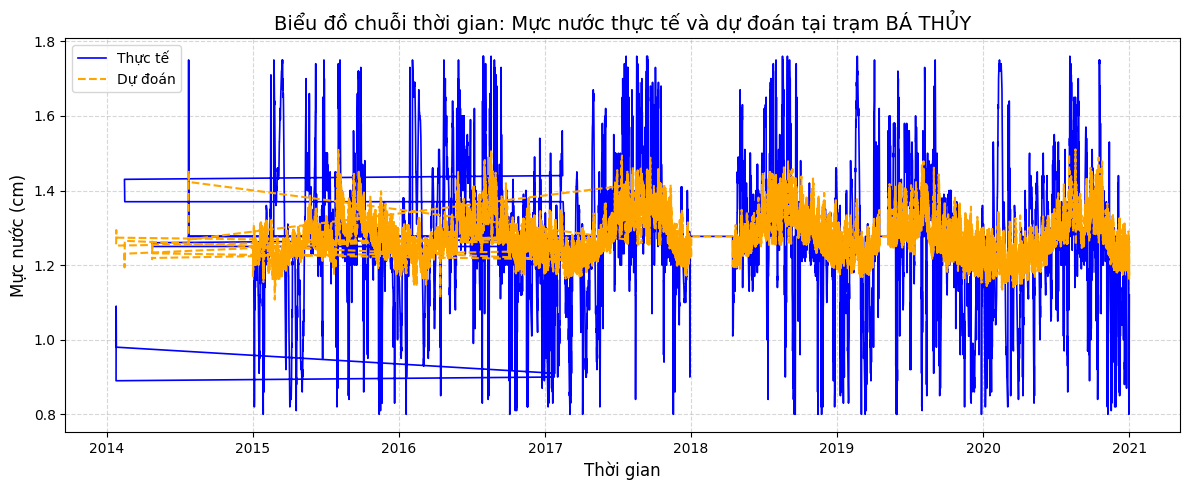

In [19]:
#beta1 # beta2 #beta3 #1(2)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import curve_fit

# 1. ƒê·ªçc d·ªØ li·ªáu
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# 2. C·ªôt ƒë·∫ßu v√†o v√† ƒë·∫ßu ra
feature_cols = ['X. QUAN', 'C·∫¶U C·∫§T', 'C·∫¶U XE', 'AN TH·ªî', 'L·ª∞C ƒêI·ªÄN']
target_col = 'B√Å THU·ª∂'

df = df[feature_cols + [target_col]].apply(pd.to_numeric, errors='coerce').dropna()

# 3. T·∫°o tr·ªÖ
def create_lagged_features(data, feature_cols, target_col, n_lags=1):
    df = data.copy()
    for col in feature_cols + [target_col]:
        for lag in range(1, n_lags+1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df.dropna()

df_lagged = create_lagged_features(df, feature_cols, target_col, n_lags=1)

# 4. Ch·ªâ l·∫•y 3 bi·∫øn ƒë·∫ßu v·ªõi lag=1
X3 = df_lagged[['X. QUAN_lag1', 'C·∫¶U C·∫§T_lag1', 'C·∫¶U XE_lag1']]
y = df_lagged[target_col]

# 5. Chu·∫©n h√≥a
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X3)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# 6. D√πng to√†n b·ªô d·ªØ li·ªáu (kh√¥ng chia train/test)
X_full = X_scaled
y_full = y_scaled

# 7. T√°ch H1, H2, H3 v√† tr√°nh s·ªë m≈© g·∫ßn 0
epsilon = 1e-4
H1, H2, H3 = X_full.T + epsilon

# 8. ƒê·ªãnh nghƒ©a m√¥ h√¨nh phi tuy·∫øn
def nonlinear_model(X, alpha1, beta1, alpha2, beta2, alpha3, beta3, alpha4):
    H1, H2, H3 = X
    return alpha1 * H1**beta1 + alpha2 * H2**beta2 + alpha3 * H3**beta3 + alpha4

# 9. Hu·∫•n luy·ªán m√¥ h√¨nh
initial_guess = [1, 1, 1, 1, 1, 1, 1]
params, _ = curve_fit(
    nonlinear_model,
    (H1, H2, H3),
    y_full,
    p0=initial_guess,
    maxfev=50000
)

# 10. In h·ªá s·ªë m√¥ h√¨nh
alpha1, beta1, alpha2, beta2, alpha3, beta3, alpha4 = params
print(f"alpha1={alpha1:.4f}, beta1={beta1:.4f}")
print(f"alpha2={alpha2:.4f}, beta2={beta2:.4f}")
print(f"alpha3={alpha3:.4f}, beta3={beta3:.4f}")
print(f"alpha4={alpha4:.4f}")

# 11. D·ª± ƒëo√°n
y_pred_scaled = nonlinear_model((H1, H2, H3), *params)

# 12. Inverse transform
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_orig = scaler_y.inverse_transform(y_full.reshape(-1, 1)).flatten()

# 13. ƒê√°nh gi√° m√¥ h√¨nh
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

mae, mse, rmse, r2 = evaluate_model(y_orig, y_pred)

# 14. In k·∫øt qu·∫£
print("\nƒê√°nh gi√° m√¥ h√¨nh tr√™n TO√ÄN B·ªò D·ªÆ LI·ªÜU:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# 15. Bi·ªÉu ƒë·ªì chu·ªói th·ªùi gian: Th·ª±c t·∫ø vs D·ª± ƒëo√°n
plt.figure(figsize=(12, 5))
plt.plot(df_lagged.index, y_orig, label='Th·ª±c t·∫ø', color='blue', linewidth=1.2)
plt.plot(df_lagged.index, y_pred, label='D·ª± ƒëo√°n', color='orange', linestyle='--')
plt.xlabel("Th·ªùi gian", fontsize=12)
plt.ylabel("M·ª±c n∆∞·ªõc (cm)", fontsize=12)
plt.title("Bi·ªÉu ƒë·ªì chu·ªói th·ªùi gian: M·ª±c n∆∞·ªõc th·ª±c t·∫ø v√† d·ª± ƒëo√°n t·∫°i tr·∫°m B√Å TH·ª¶Y", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



Ph∆∞∆°ng tr√¨nh h·ªìi quy:
H = Œ±1¬∑H1 + Œ±2¬∑H2 + Œ±3¬∑H3 + Œ±4
Œ±1 = 0.1525
Œ±2 = 0.0052
Œ±3 = 0.1002
Œ±4 = 0.2152

ƒê√°nh gi√° m√¥ h√¨nh tr√™n TO√ÄN B·ªò T·∫¨P D·ªÆ LI·ªÜU:
MAE:  0.1228
MSE:  0.0273
RMSE: 0.1653
R2 Score: 0.1667


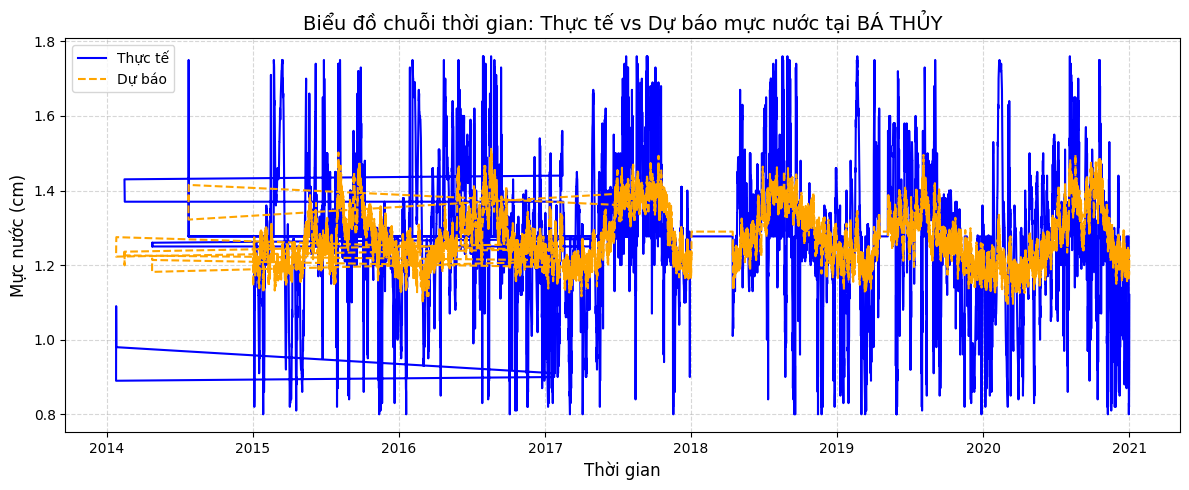

In [17]:
#beta1 = beta2 = beta3 = 1(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import curve_fit

# 1. ƒê·ªçc d·ªØ li·ªáu
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# 2. Ch·ªçn c·ªôt ƒë·∫ßu v√†o v√† ƒë·∫ßu ra
feature_cols = ['X. QUAN', 'C·∫¶U C·∫§T', 'C·∫¶U XE', 'AN TH·ªî', 'L·ª∞C ƒêI·ªÄN']
target_col = 'B√Å THU·ª∂'
df = df[feature_cols + [target_col]].apply(pd.to_numeric, errors='coerce').dropna()

# 3. T·∫°o ƒë·∫∑c tr∆∞ng tr·ªÖ
def create_lagged_features(data, feature_cols, target_col, n_lags=3):
    df = data.copy()
    for col in feature_cols + [target_col]:
        for lag in range(1, n_lags + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df.dropna()

df_lagged = create_lagged_features(df, feature_cols, target_col, n_lags=3)

# 4. T√≠nh H1, H2, H3
H1 = df_lagged[[f'{col}_lag1' for col in feature_cols]].mean(axis=1).values
H2 = df_lagged[[f'{col}_lag2' for col in feature_cols]].mean(axis=1).values
H3 = df_lagged[[f'{col}_lag3' for col in feature_cols]].mean(axis=1).values
y = df_lagged[target_col].values

# 5. Chu·∫©n h√≥a y
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# 6. Gh√©p H1, H2, H3
X = np.vstack((H1, H2, H3)).T

# 7. M√¥ h√¨nh tuy·∫øn t√≠nh: y = alpha1*H1 + alpha2*H2 + alpha3*H3 + alpha4
def linear_model(X, alpha1, alpha2, alpha3, alpha4):
    H1, H2, H3 = X
    return alpha1 * H1 + alpha2 * H2 + alpha3 * H3 + alpha4

# 8. Hu·∫•n luy·ªán m√¥ h√¨nh tr√™n TO√ÄN B·ªò t·∫≠p
initial_guess = [0.3, 0.3, 0.3, 0.1]
params, _ = curve_fit(linear_model, X.T, y_scaled, p0=initial_guess)

# 9. D·ª± ƒëo√°n tr√™n TO√ÄN B·ªò t·∫≠p
y_pred_scaled = linear_model(X.T, *params)

# 10. ƒê·∫£o chu·∫©n h√≥a
y_orig = scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# 11. ƒê√°nh gi√° m√¥ h√¨nh
mae = mean_absolute_error(y_orig, y_pred)
mse = mean_squared_error(y_orig, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_orig, y_pred)

# 12. In h·ªá s·ªë
print("\nPh∆∞∆°ng tr√¨nh h·ªìi quy:")
print(f"H = Œ±1¬∑H1 + Œ±2¬∑H2 + Œ±3¬∑H3 + Œ±4")
print(f"Œ±1 = {params[0]:.4f}")
print(f"Œ±2 = {params[1]:.4f}")
print(f"Œ±3 = {params[2]:.4f}")
print(f"Œ±4 = {params[3]:.4f}")

# 13. In ƒë√°nh gi√° m√¥ h√¨nh
print("\nƒê√°nh gi√° m√¥ h√¨nh tr√™n TO√ÄN B·ªò T·∫¨P D·ªÆ LI·ªÜU:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# 14. Bi·ªÉu ƒë·ªì chu·ªói th·ªùi gian: So s√°nh y th·ª±c t·∫ø v√† y d·ª± b√°o
plt.figure(figsize=(12, 5))
plt.plot(df_lagged.index, y_orig, label='Th·ª±c t·∫ø', color='blue', linewidth=1.5)
plt.plot(df_lagged.index, y_pred, label='D·ª± b√°o', color='orange', linestyle='--')
plt.xlabel("Th·ªùi gian", fontsize=12)
plt.ylabel("M·ª±c n∆∞·ªõc (cm)", fontsize=12)
plt.title("Bi·ªÉu ƒë·ªì chu·ªói th·ªùi gian: Th·ª±c t·∫ø vs D·ª± b√°o m·ª±c n∆∞·ªõc t·∫°i B√Å TH·ª¶Y", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



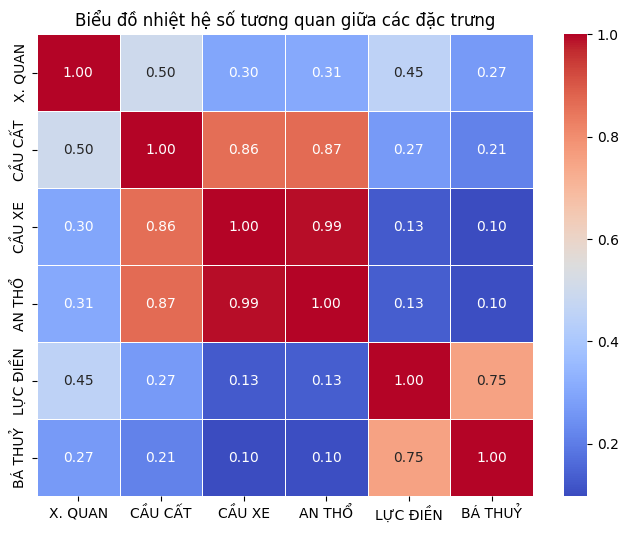

In [ ]:
# Bi·ªÉu ƒë·ªì t∆∞∆°ng quan
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Gi·∫£ s·ª≠ b·∫°n c√≥ m·ªôt DataFrame df ch·ª©a c√°c ƒë·∫∑c tr∆∞ng
corr_matrix = df.corr()  # T√≠nh ma tr·∫≠n h·ªá s·ªë t∆∞∆°ng quan

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Bi·ªÉu ƒë·ªì nhi·ªát h·ªá s·ªë t∆∞∆°ng quan gi·ªØa c√°c ƒë·∫∑c tr∆∞ng")
plt.show()


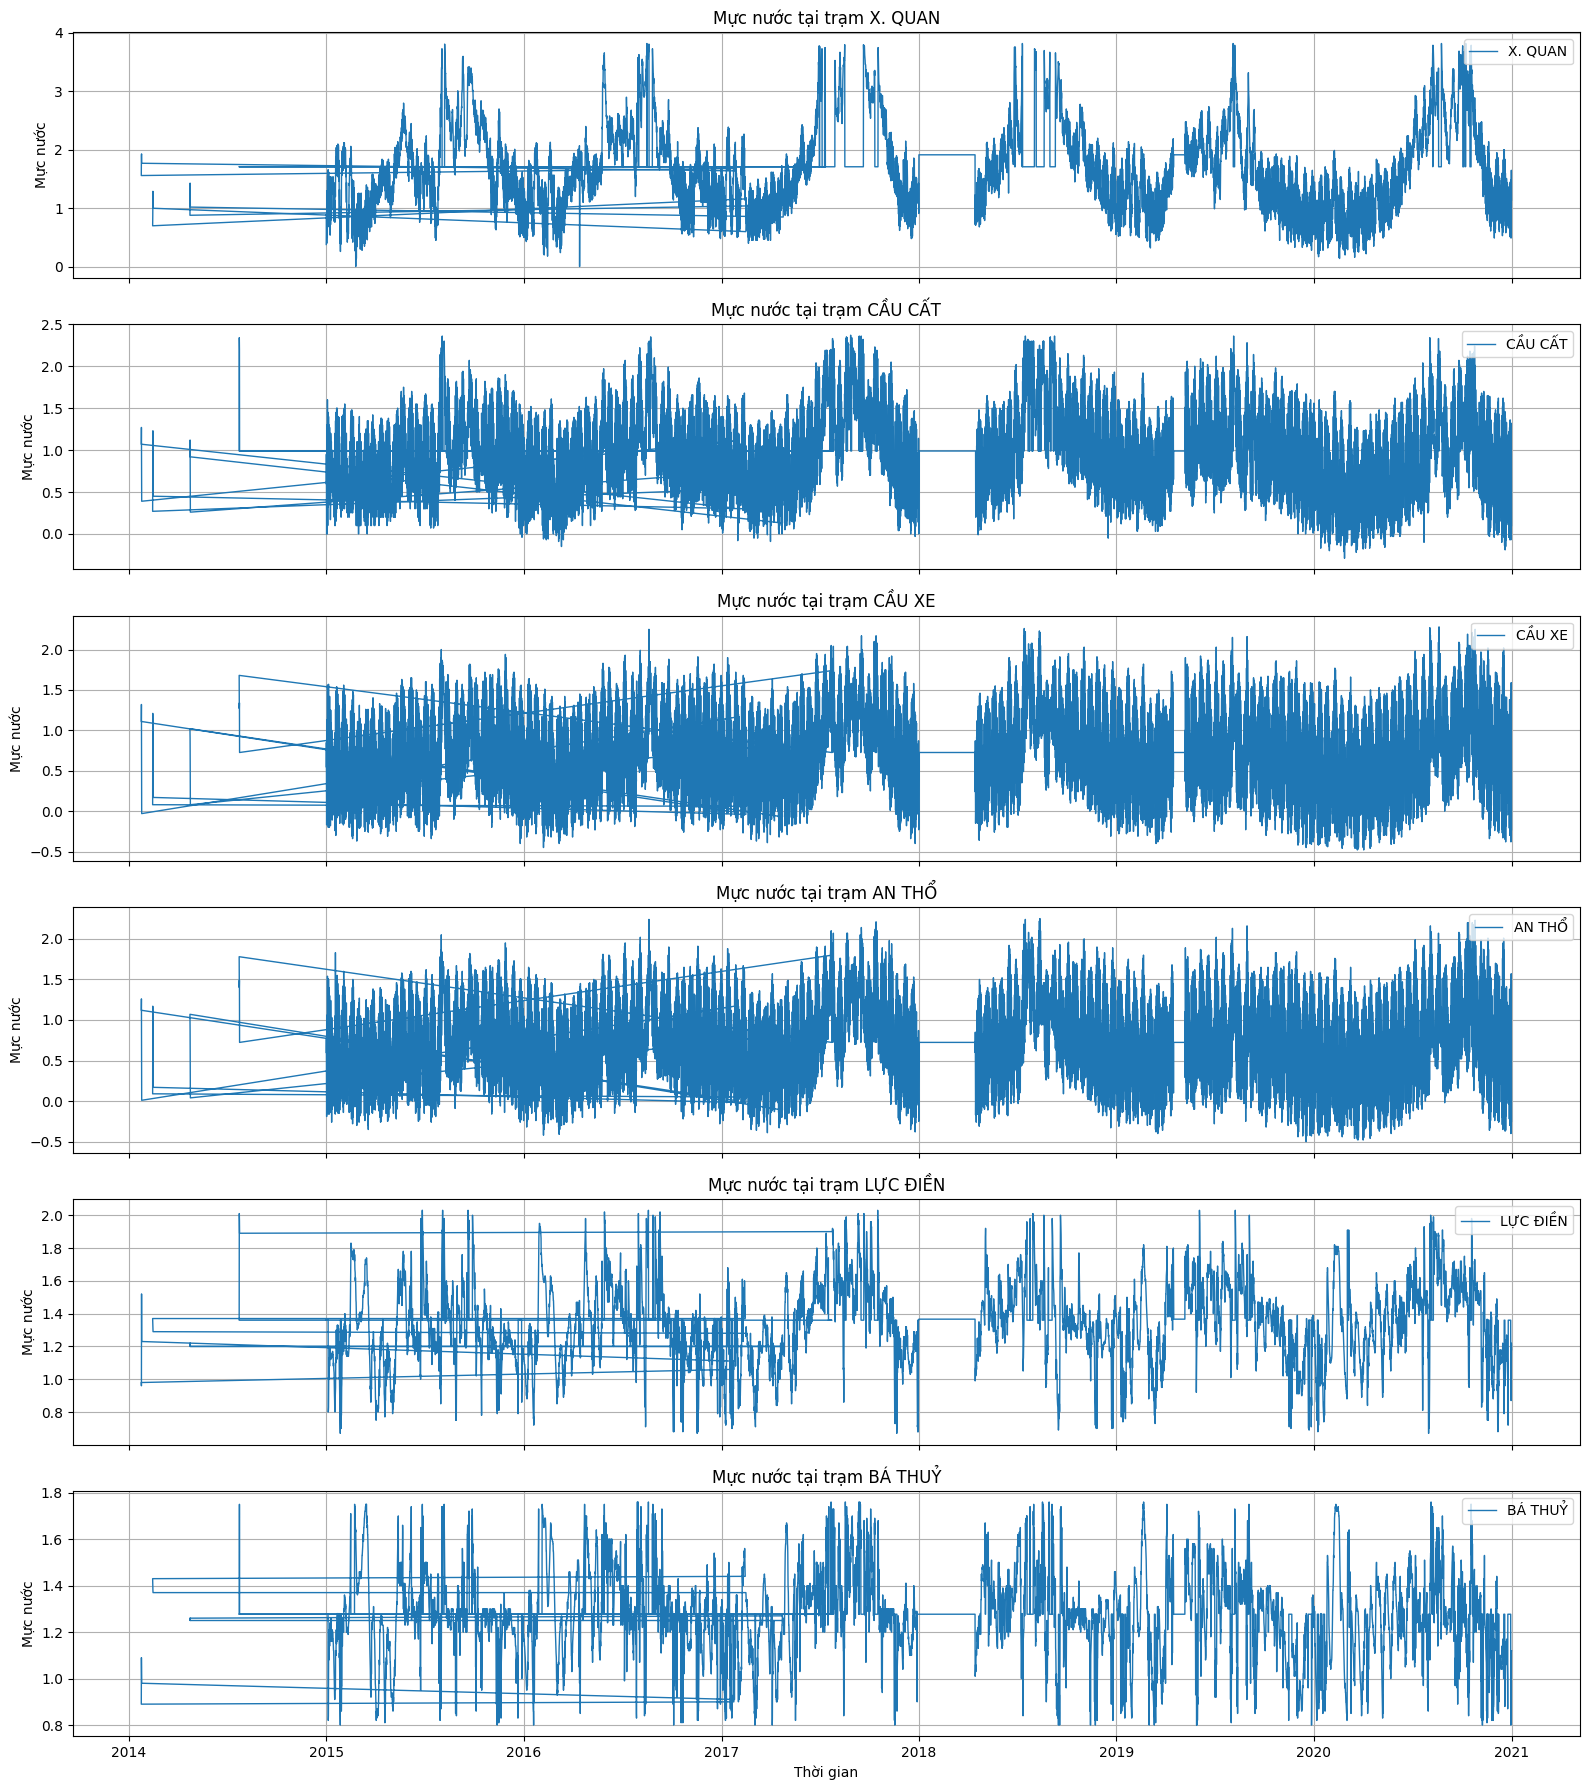

In [ ]:
# Bi·ªÉu ƒë·ªì ƒë∆∞·ªùng
import pandas as pd
import matplotlib.pyplot as plt

# ƒê·ªçc d·ªØ li·ªáu t·ª´ file Excel
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx", sheet_name="Danh_gia", parse_dates=["Datetime"])

# Chuy·ªÉn c·ªôt th·ªùi gian v·ªÅ d·∫°ng datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Thi·∫øt l·∫≠p c·ªôt th·ªùi gian l√†m index
df.set_index('Datetime', inplace=True)

# Danh s√°ch c√°c tr·∫°m th·ªßy vƒÉn c·∫ßn v·∫Ω
stations = ['X. QUAN', 'C·∫¶U C·∫§T', 'C·∫¶U XE', 'AN TH·ªî', 'L·ª∞C ƒêI·ªÄN', 'B√Å THU·ª∂']

# Thi·∫øt l·∫≠p s·ªë l∆∞·ª£ng bi·ªÉu ƒë·ªì (1 tr·∫°m = 1 subplot)
fig, axs = plt.subplots(len(stations), 1, figsize=(16, 18), sharex=True)

# V·∫Ω t·ª´ng bi·ªÉu ƒë·ªì cho t·ª´ng tr·∫°m
for i, station in enumerate(stations):
    axs[i].plot(df.index, df[station], label=station, linewidth=1)
    axs[i].set_title(f"M·ª±c n∆∞·ªõc t·∫°i tr·∫°m {station}")
    axs[i].set_ylabel("M·ª±c n∆∞·ªõc")
    axs[i].legend(loc="upper right")
    axs[i].grid(True)

plt.xlabel("Th·ªùi gian")
plt.tight_layout()
plt.show()


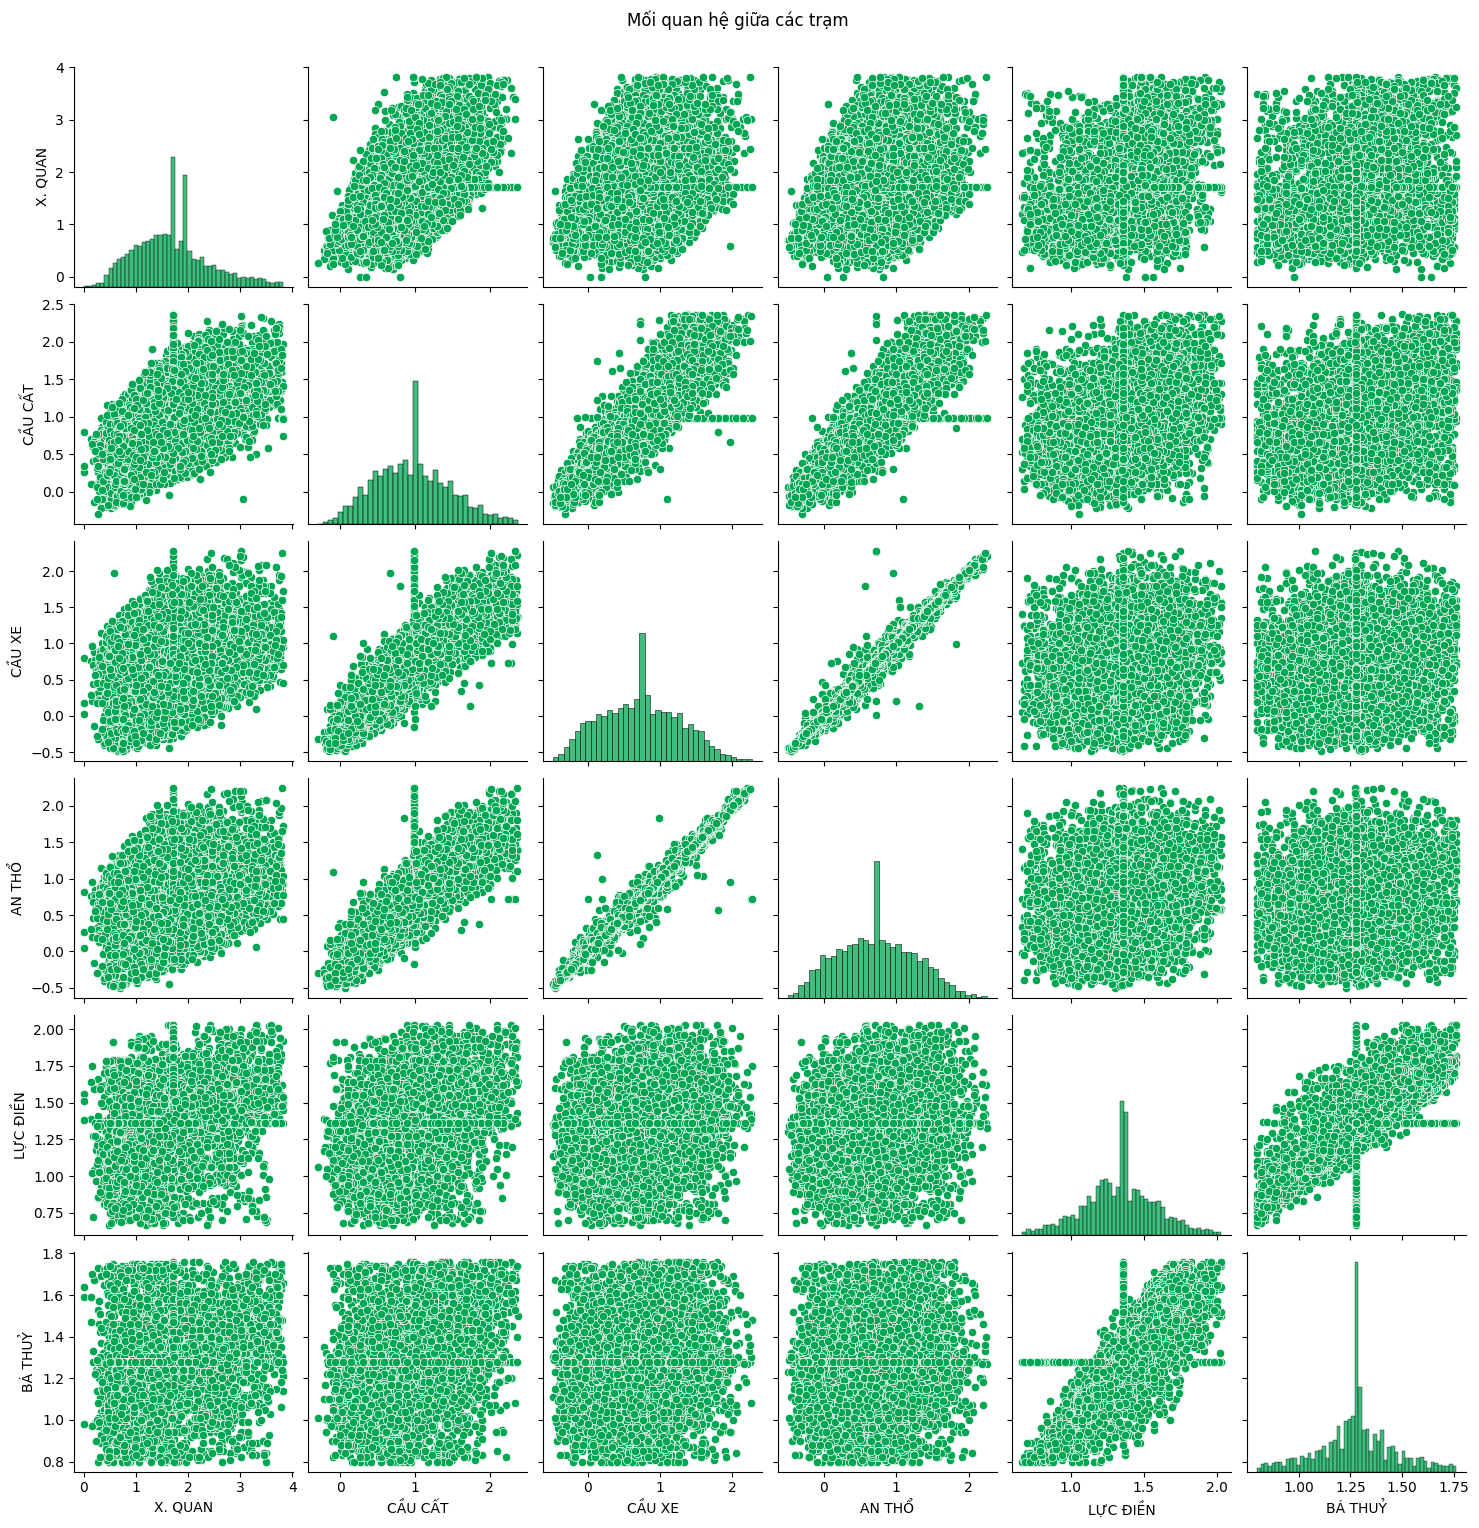

In [ ]:
#bi·ªÉu ƒë·ªì t√°n x·∫°
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ƒê·ªçc d·ªØ li·ªáu
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx", sheet_name="Danh_gia", parse_dates=["Datetime"])

# Ch·ªçn c√°c c·ªôt tr·∫°m c·∫ßn ph√¢n t√≠ch
stations = ['X. QUAN', 'C·∫¶U C·∫§T', 'C·∫¶U XE', 'AN TH·ªî', 'L·ª∞C ƒêI·ªÄN', 'B√Å THU·ª∂']

# V·∫Ω bi·ªÉu ƒë·ªì ma tr·∫≠n t√°n x·∫° v·ªõi m√†u xanh l√°
sns.pairplot(
    df[stations],
    plot_kws={'color': '#00a651'},      # m√†u ƒëi·ªÉm trong scatter plot
    diag_kws={'color': '#00a651', 'fill': True}  # m√†u histogram ƒë∆∞·ªùng ch√©o
)

plt.suptitle("M·ªëi quan h·ªá gi·ªØa c√°c tr·∫°m", y=1.02)
plt.show()


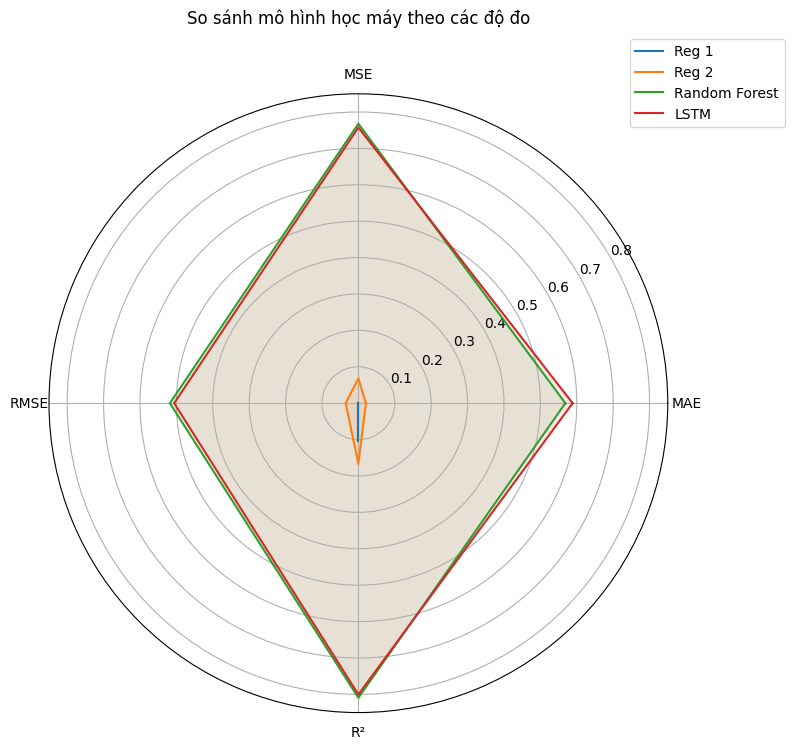

In [ ]:
# Bi·ªÉu ƒë·ªì radar
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# T√™n m√¥ h√¨nh v√† c√°c ƒë·ªô ƒëo
models = ['Reg 1', 'Reg 2', 'Random Forest', 'LSTM']
metrics = ['MAE', 'MSE', 'RMSE', 'R¬≤']

# D·ªØ li·ªáu (gi√° tr·ªã g·ªëc)
data = [
    [0.1254, 0.0293, 0.1713, 0.1047],  # Reg 1
    [0.1228, 0.0273, 0.1653, 0.1667],  # Reg 2
    [0.0541, 0.0068, 0.0826, 0.8095],  # RF
    [0.0516, 0.0071, 0.0846, 0.8004]   # LSTM
]

# ƒê·∫£o MAE, MSE, RMSE (c√†ng nh·ªè c√†ng t·ªët)
data_norm = []
for i in range(len(metrics)):
    col = [row[i] for row in data]
    if metrics[i] in ['MAE', 'MSE', 'RMSE']:
        max_val = max(col)
        norm_col = [1 - x / max_val for x in col]
    else:
        norm_col = [x for x in col]  # R¬≤ gi·ªØ nguy√™n
    for j in range(len(models)):
        if i == 0:
            data_norm.append([norm_col[j]])
        else:
            data_norm[j].append(norm_col[j])

# V·∫Ω bi·ªÉu ƒë·ªì radar
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, model in enumerate(models):
    values = data_norm[i]
    values += values[:1]
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], metrics)
ax.set_title("So s√°nh m√¥ h√¨nh h·ªçc m√°y theo c√°c ƒë·ªô ƒëo", y=1.1)
ax.set_rlabel_position(30)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


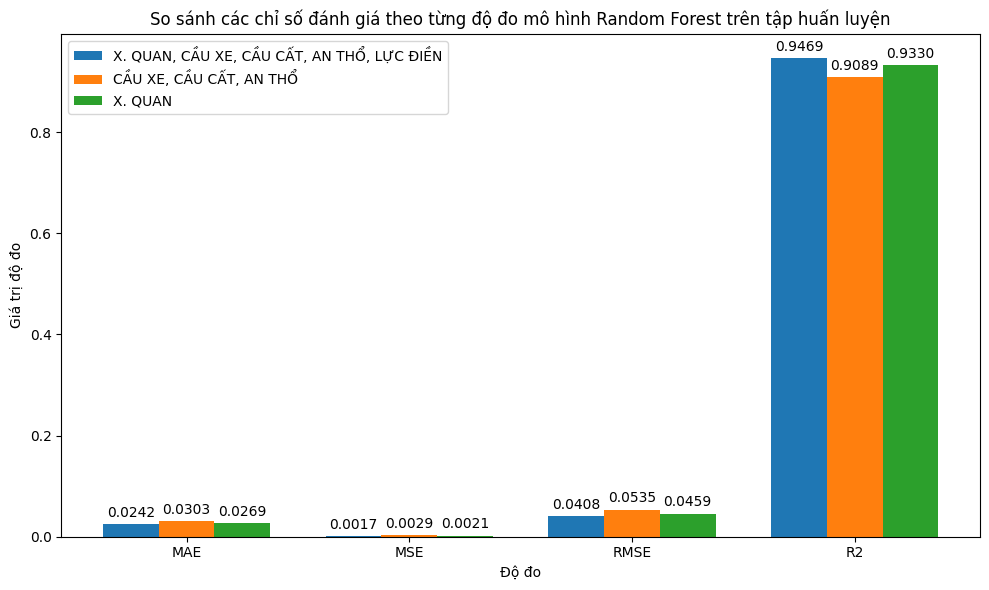

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# D·ªØ li·ªáu t·ª´ bi·ªÉu ƒë·ªì c·ªßa b·∫°n
labels = ['MAE', 'MSE', 'RMSE', 'R2']
group1 = [0.0242, 0.0017, 0.0408, 0.9469]  # X. QUAN, C·∫¶U XE, C·∫¶U C·∫§T, AN TH·ªî, L·ª∞C ƒêI·ªÄN
group2 = [0.0303, 0.0029, 0.0535, 0.9089]  # C·∫¶U XE, C·∫¶U C·∫§T, AN TH·ªî
group3 = [0.0269, 0.0021, 0.0459, 0.9330]  # X. QUAN

# Gom l·∫°i theo t·ª´ng ƒë·ªô ƒëo
data = np.array([group1, group2, group3]).T  # shape (4, 3)

x = np.arange(len(labels))  # nh√£n tr·ª•c x
width = 0.25  # ƒë·ªô r·ªông c·ªßa m·ªói c·ªôt

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, data[:, 0], width, label='X. QUAN, C·∫¶U XE, C·∫¶U C·∫§T, AN TH·ªî, L·ª∞C ƒêI·ªÄN')
rects2 = ax.bar(x, data[:, 1], width, label='C·∫¶U XE, C·∫¶U C·∫§T, AN TH·ªî')
rects3 = ax.bar(x + width, data[:, 2], width, label='X. QUAN')

# Nh√£n v√† ƒë·ªãnh d·∫°ng
ax.set_xlabel('ƒê·ªô ƒëo')
ax.set_ylabel('Gi√° tr·ªã ƒë·ªô ƒëo')
ax.set_title('So s√°nh c√°c ch·ªâ s·ªë ƒë√°nh gi√° theo t·ª´ng ƒë·ªô ƒëo m√¥ h√¨nh Random Forest tr√™n t·∫≠p hu·∫•n luy·ªán')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Hi·ªÉn th·ªã gi√° tr·ªã tr√™n ƒë·ªânh c·ªôt
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # kho·∫£ng c√°ch ph√≠a tr√™n
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


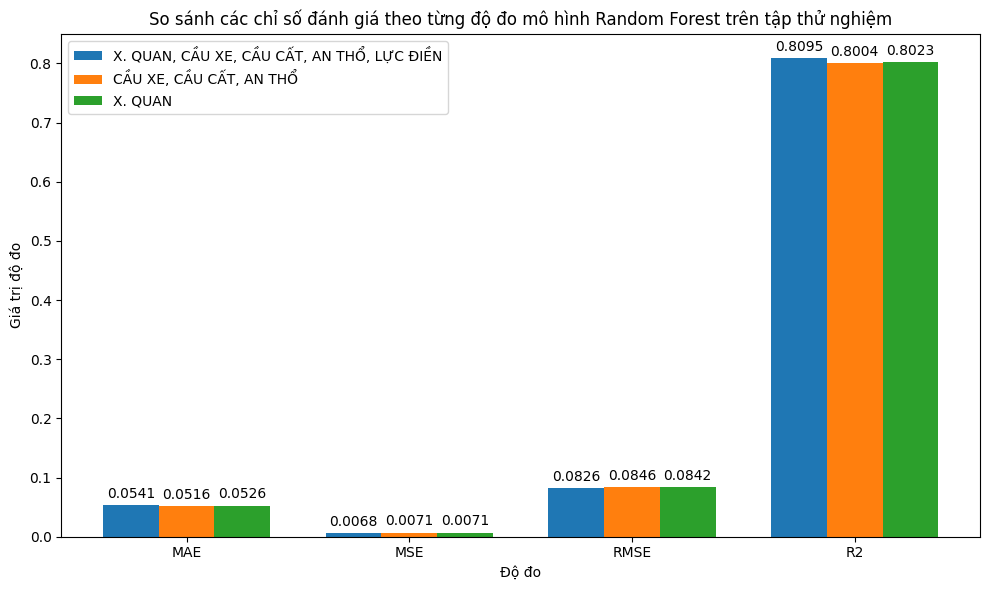

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# D·ªØ li·ªáu ƒë·ªô ƒëo t·ª´ bi·ªÉu ƒë·ªì t·∫≠p th·ª≠ nghi·ªám
labels = ['MAE', 'MSE', 'RMSE', 'R2']
group1 = [0.0541, 0.0068, 0.0826, 0.8095]  # T·ªï h·ª£p 1
group2 = [0.0516, 0.0071, 0.0846, 0.8004]  # T·ªï h·ª£p 2
group3 = [0.0526, 0.0071, 0.0842, 0.8023]  # T·ªï h·ª£p 3

# Chuy·ªÉn th√†nh d·∫°ng ph√π h·ª£p cho v·∫Ω c·ªôt
data = np.array([group1, group2, group3]).T  # shape (4, 3)

x = np.arange(len(labels))  # MAE, MSE, ...
width = 0.25  # ƒê·ªô r·ªông c·ªßa m·ªói c·ªôt

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, data[:, 0], width, label='X. QUAN, C·∫¶U XE, C·∫¶U C·∫§T, AN TH·ªî, L·ª∞C ƒêI·ªÄN')
rects2 = ax.bar(x, data[:, 1], width, label='C·∫¶U XE, C·∫¶U C·∫§T, AN TH·ªî')
rects3 = ax.bar(x + width, data[:, 2], width, label='X. QUAN')

# C√†i ƒë·∫∑t tr·ª•c v√† ti√™u ƒë·ªÅ
ax.set_xlabel('ƒê·ªô ƒëo')
ax.set_ylabel('Gi√° tr·ªã ƒë·ªô ƒëo')
ax.set_title('So s√°nh c√°c ch·ªâ s·ªë ƒë√°nh gi√° theo t·ª´ng ƒë·ªô ƒëo m√¥ h√¨nh Random Forest tr√™n t·∫≠p th·ª≠ nghi·ªám')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Ghi gi√° tr·ªã l√™n ƒë·∫ßu m·ªói c·ªôt
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


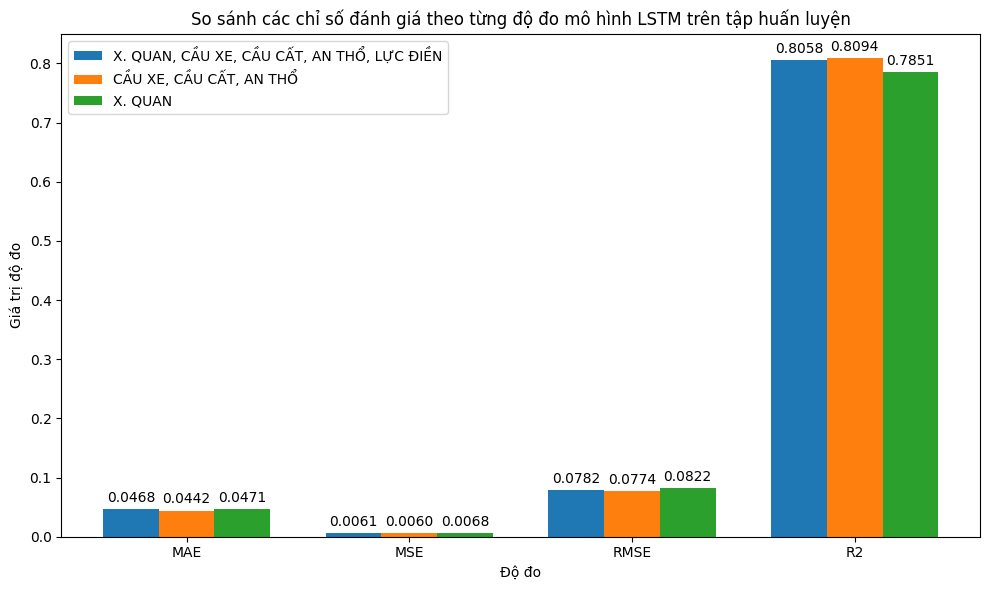

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Nh√£n ƒë·ªô ƒëo
labels = ['MAE', 'MSE', 'RMSE', 'R2']

# D·ªØ li·ªáu t·ª´ bi·ªÉu ƒë·ªì b·∫°n g·ª≠i (theo th·ª© t·ª±: 4 tr·∫°m, 3 tr·∫°m, X. QUAN)
group1 = [0.0468, 0.0061, 0.0782, 0.8058]
group2 = [0.0442, 0.0060, 0.0774, 0.8094]
group3 = [0.0471, 0.0068, 0.0822, 0.7851]

data = np.array([group1, group2, group3]).T

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, data[:, 0], width, label='X. QUAN, C·∫¶U XE, C·∫¶U C·∫§T, AN TH·ªî, L·ª∞C ƒêI·ªÄN')
rects2 = ax.bar(x, data[:, 1], width, label='C·∫¶U XE, C·∫¶U C·∫§T, AN TH·ªî')
rects3 = ax.bar(x + width, data[:, 2], width, label='X. QUAN')

ax.set_xlabel('ƒê·ªô ƒëo')
ax.set_ylabel('Gi√° tr·ªã ƒë·ªô ƒëo')
ax.set_title('So s√°nh c√°c ch·ªâ s·ªë ƒë√°nh gi√° theo t·ª´ng ƒë·ªô ƒëo m√¥ h√¨nh LSTM tr√™n t·∫≠p hu·∫•n luy·ªán')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Ghi nh√£n gi√° tr·ªã
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


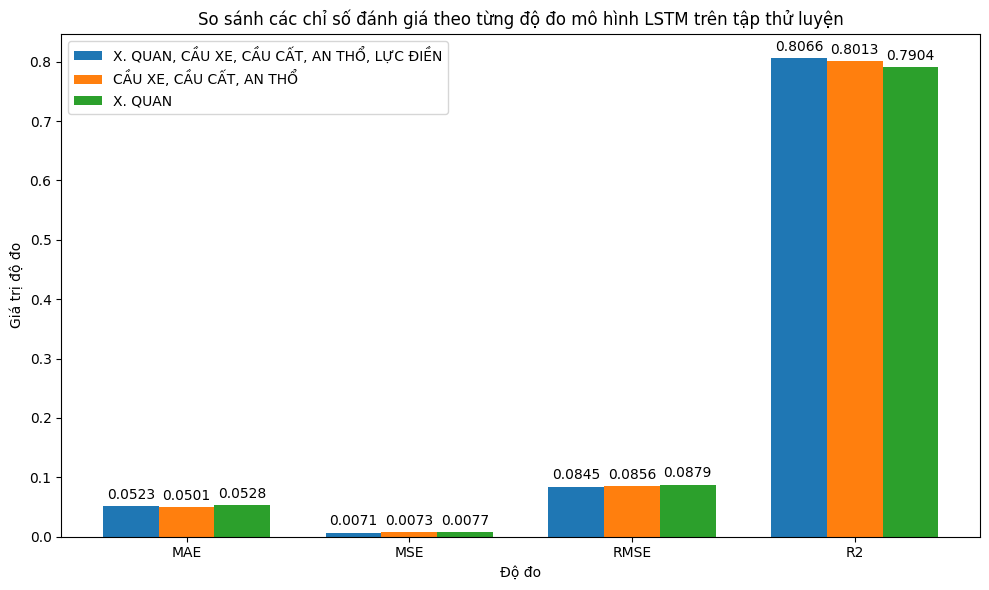

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Nh√£n ƒë·ªô ƒëo
labels = ['MAE', 'MSE', 'RMSE', 'R2']

# D·ªØ li·ªáu t·ª´ bi·ªÉu ƒë·ªì b·∫°n g·ª≠i (theo th·ª© t·ª±: 4 tr·∫°m, 3 tr·∫°m, X. QUAN)
group1 = [0.0523, 0.0071, 0.0845, 0.8066]  # 5 tr·∫°m
group2 = [0.0501, 0.0073, 0.0856, 0.8013]  # 3 tr·∫°m
group3 = [0.0528, 0.0077, 0.0879, 0.7904] 

data = np.array([group1, group2, group3]).T

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, data[:, 0], width, label='X. QUAN, C·∫¶U XE, C·∫¶U C·∫§T, AN TH·ªî, L·ª∞C ƒêI·ªÄN')
rects2 = ax.bar(x, data[:, 1], width, label='C·∫¶U XE, C·∫¶U C·∫§T, AN TH·ªî')
rects3 = ax.bar(x + width, data[:, 2], width, label='X. QUAN')

ax.set_xlabel('ƒê·ªô ƒëo')
ax.set_ylabel('Gi√° tr·ªã ƒë·ªô ƒëo')
ax.set_title('So s√°nh c√°c ch·ªâ s·ªë ƒë√°nh gi√° theo t·ª´ng ƒë·ªô ƒëo m√¥ h√¨nh LSTM tr√™n t·∫≠p th·ª≠ luy·ªán')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Ghi nh√£n gi√° tr·ªã
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


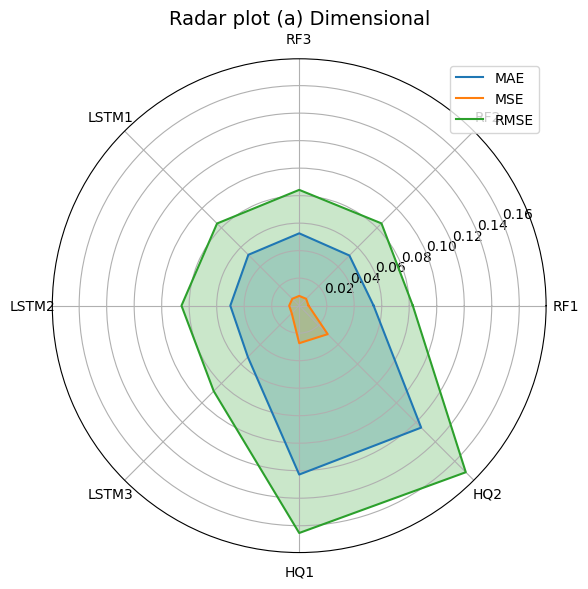

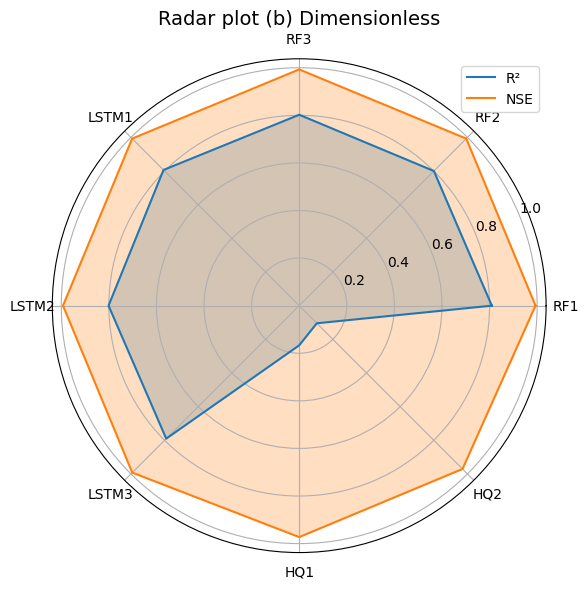

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# T√™n m√¥ h√¨nh
models = ['RF1', 'RF2', 'RF3', 'LSTM1', 'LSTM2', 'LSTM3', 'HQ1', 'HQ2']

# C√°c ƒë·ªô ƒëo ƒë√°nh gi√°
mae = [0.0541, 0.0516, 0.0526, 0.0523, 0.0501, 0.0528, 0.1228, 0.1254]
mse = [0.0068, 0.0071, 0.0071, 0.0071, 0.0073, 0.0077, 0.0273, 0.0293]
rmse = [0.0826, 0.0846, 0.0842, 0.0845, 0.0856, 0.0879, 0.1653, 0.1713]
r2 = [0.8095, 0.8004, 0.8023, 0.8066, 0.8013, 0.7904, 0.1667, 0.1047]

# H√†m v·∫Ω bi·ªÉu ƒë·ªì radar
def plot_radar(title, labels, data_series, series_labels):
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]  # Kh√©p k√≠n h√¨nh

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
    for data, label in zip(data_series, series_labels):
        values = data + data[:1]
        ax.plot(angles, values, label=label)
        ax.fill(angles, values, alpha=0.25)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(title, fontsize=14)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Bi·ªÉu ƒë·ªì c√≥ th·ª© nguy√™n
plot_radar("Radar plot (a) Dimensional", models, [mae, mse, rmse], ["MAE", "MSE", "RMSE"])

# Bi·ªÉu ƒë·ªì kh√¥ng c√≥ th·ª© nguy√™n
plot_radar("Radar plot (b) Dimensionless", models, [r2, [1 - x for x in mse]], ["R¬≤", "NSE"])


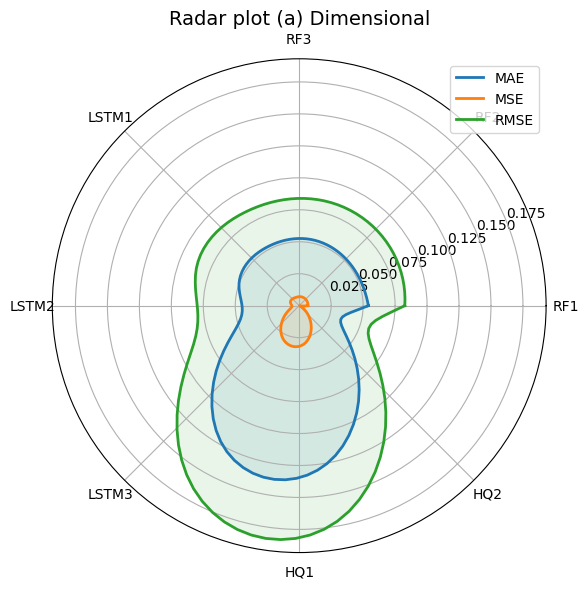

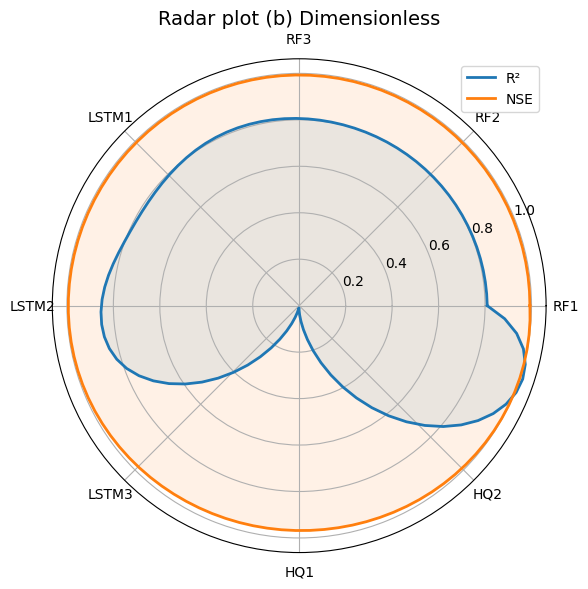

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# T√™n m√¥ h√¨nh
models = ['RF1', 'RF2', 'RF3', 'LSTM1', 'LSTM2', 'LSTM3', 'HQ1', 'HQ2']

# ƒê·ªô ƒëo ƒë√°nh gi√°
mae = [0.0541, 0.0516, 0.0526, 0.0523, 0.0501, 0.0528, 0.1228, 0.1254]
mse = [0.0068, 0.0071, 0.0071, 0.0071, 0.0073, 0.0077, 0.0273, 0.0293]
rmse = [0.0826, 0.0846, 0.0842, 0.0845, 0.0856, 0.0879, 0.1653, 0.1713]
r2 = [0.8095, 0.8004, 0.8023, 0.8066, 0.8013, 0.7904, 0.1667, 0.1047]
nse = [1 - x for x in mse]

def interpolate(values, resolution=100):
    values = values + values[:1]  # kh√©p k√≠n
    x = np.linspace(0, len(values) - 1, len(values))
    f = interp1d(x, values, kind='cubic')
    x_new = np.linspace(0, len(values) - 1, resolution)
    y_new = f(x_new)
    return x_new, y_new

def plot_smooth_radar(title, labels, data_series, series_labels):
    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # kh√©p k√≠n

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

    for values, label in zip(data_series, series_labels):
        vals = values + values[:1]
        theta = np.linspace(0, 2 * np.pi, len(vals))
        interp_theta, interp_vals = interpolate(vals)
        interp_theta = np.linspace(0, 2 * np.pi, len(interp_vals))
        ax.plot(interp_theta, interp_vals, label=label, linewidth=2)
        ax.fill(interp_theta, interp_vals, alpha=0.1)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=10)
    ax.set_title(title, fontsize=14)
    ax.grid(True)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# üîπ Radar plot (a): C√≥ th·ª© nguy√™n
plot_smooth_radar("Radar plot (a) Dimensional", models, [mae, mse, rmse], ["MAE", "MSE", "RMSE"])

# üîπ Radar plot (b): Kh√¥ng c√≥ th·ª© nguy√™n
plot_smooth_radar("Radar plot (b) Dimensionless", models, [r2, nse], ["R¬≤", "NSE"])


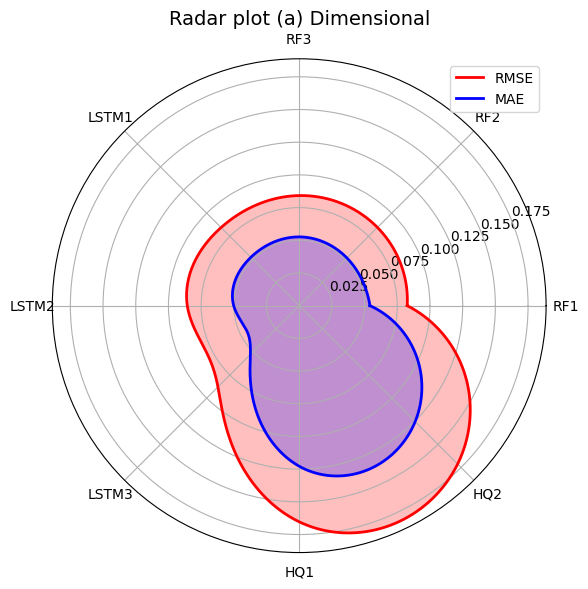

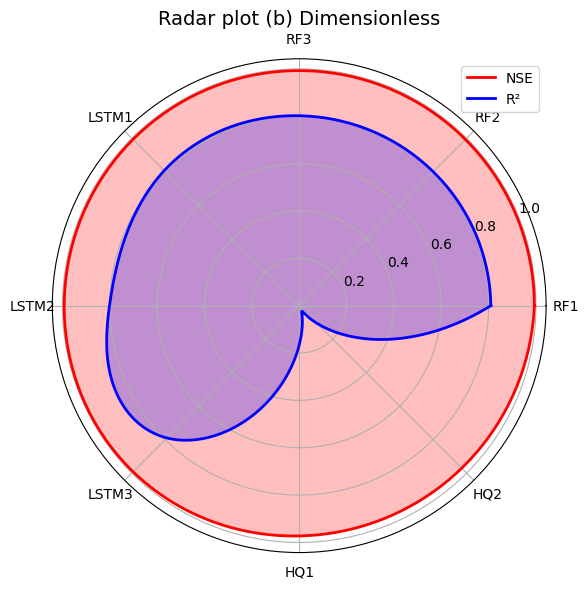

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# T√™n m√¥ h√¨nh
models = ['RF1', 'RF2', 'RF3', 'LSTM1', 'LSTM2', 'LSTM3', 'HQ1', 'HQ2']
N = len(models)

# D·ªØ li·ªáu
mae = [0.0541, 0.0516, 0.0526, 0.0523, 0.0501, 0.0528, 0.1228, 0.1254]
rmse = [0.0826, 0.0846, 0.0842, 0.0845, 0.0856, 0.0879, 0.1653, 0.1713]
mse = [0.0068, 0.0071, 0.0071, 0.0071, 0.0073, 0.0077, 0.0273, 0.0293]
r2 = [0.8095, 0.8004, 0.8023, 0.8066, 0.8013, 0.7904, 0.1667, 0.1047]
nse = [1 - x for x in mse]

# G√≥c cho c√°c tr·ª•c
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

def interpolate(values, kind='cubic', resolution=300):
    values += values[:1]
    theta = np.linspace(0, 2 * np.pi, len(values))
    f = interp1d(theta, values, kind=kind)
    theta_new = np.linspace(0, 2 * np.pi, resolution)
    values_new = f(theta_new)
    return theta_new, values_new

def plot_radar_smooth(title, labels, data_list, data_labels, colors):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
    
    for values, label, color in zip(data_list, data_labels, colors):
        theta_new, values_new = interpolate(values.copy())
        ax.plot(theta_new, values_new, label=label, color=color, linewidth=2)
        ax.fill(theta_new, values_new, color=color, alpha=0.25)
    
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=10)
    ax.set_title(title, fontsize=14)
    ax.grid(True)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# üî∏ Radar (a): C√≥ th·ª© nguy√™n
plot_radar_smooth("Radar plot (a) Dimensional", models, [rmse, mae], ["RMSE", "MAE"], ['red', 'blue'])

# üîπ Radar (b): Kh√¥ng th·ª© nguy√™n
plot_radar_smooth("Radar plot (b) Dimensionless", models, [nse, r2], ["NSE", "R¬≤"], ['red', 'blue'])
